In [1]:
# ESG Analysis using Bag-of-Words Model
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

print("BOW ESG Analysis Setup Complete")

BOW ESG Analysis Setup Complete


In [4]:
def load_company_documents():
    """Load all company documents from structured directories"""
    data_dir = "data"
    companies = ['apple', 'tesla', 'google', 'microsoft', 'nike', 'fedex']
    
    company_texts = {}
    
    for company in companies:
        company_dir = os.path.join(data_dir, company)
        if not os.path.exists(company_dir):
            print(f"Warning: {company_dir} not found")
            continue
            
        # Combine all documents for each company
        all_text = ""
        doc_count = 0
        
        # Load 10-K documents
        for item in ['10k_item1.md', '10k_item1A.md', '10k_item7.md', '10k_item7A.md']:
            file_path = os.path.join(company_dir, item)
            if os.path.exists(file_path):
                with open(file_path, 'r', encoding='utf-8') as f:
                    all_text += f.read() + "\n\n"
                    doc_count += 1
        
        # Load ESG report
        esg_path = os.path.join(company_dir, 'ESG_Report.md')
        if os.path.exists(esg_path):
            with open(esg_path, 'r', encoding='utf-8') as f:
                all_text += f.read() + "\n\n"
                doc_count += 1
        
        company_texts[company] = all_text
        print(f"{company.title()}: {doc_count} documents loaded, {len(all_text):,} characters")
    
    return company_texts

# Load company data
company_texts = load_company_documents()

Apple: 5 documents loaded, 497,893 characters
Tesla: 5 documents loaded, 229,439 characters
Google: 5 documents loaded, 490,638 characters
Microsoft: 5 documents loaded, 440,569 characters
Nike: 5 documents loaded, 659,455 characters
Fedex: 5 documents loaded, 426,490 characters


In [5]:
# ESG Keywords Dictionary for Scoring
esg_keywords = {
    'Environment': {
        'Emissions': [
            'carbon', 'emissions', 'greenhouse gas', 'ghg', 'co2', 'carbon dioxide', 
            'carbon footprint', 'carbon neutral', 'carbon reduction', 'decarbonization',
            'net zero', 'climate change', 'global warming', 'carbon intensity',
            'scope 1', 'scope 2', 'scope 3', 'carbon offset', 'carbon capture'
        ],
        'Resource Use': [
            'energy', 'renewable energy', 'solar', 'wind', 'water', 'electricity',
            'energy efficiency', 'energy consumption', 'water consumption', 'water usage',
            'recycling', 'waste management', 'circular economy', 'sustainable materials',
            'resource conservation', 'energy saving', 'water conservation', 'renewable'
        ],
        'Innovation': [
            'green technology', 'clean technology', 'sustainable innovation', 'eco-friendly',
            'environmental innovation', 'green products', 'sustainable products',
            'clean energy', 'green initiatives', 'environmental technology', 'sustainability innovation',
            'green research', 'environmental research', 'sustainable development', 'green solutions'
        ]
    },
    'Social': {
        'Human Rights': [
            'human rights', 'labor rights', 'worker rights', 'fair labor', 'ethical sourcing',
            'supply chain', 'modern slavery', 'child labor', 'forced labor', 'fair trade',
            'worker safety', 'workplace safety', 'occupational health', 'labor standards',
            'human trafficking', 'ethical practices', 'responsible sourcing'
        ],
        'Product Responsibility': [
            'product safety', 'consumer protection', 'product quality', 'product liability',
            'customer safety', 'safety standards', 'quality control', 'product recalls',
            'consumer rights', 'product testing', 'safety testing', 'responsible marketing',
            'data privacy', 'privacy protection', 'cybersecurity', 'data security'
        ],
        'Workforce': [
            'diversity', 'inclusion', 'equity', 'dei', 'employee', 'workforce', 'talent',
            'training', 'development', 'employee satisfaction', 'work-life balance',
            'compensation', 'benefits', 'equal opportunity', 'discrimination', 'harassment',
            'employee engagement', 'career development', 'workplace culture', 'retention'
        ],
        'Community': [
            'community', 'philanthropy', 'charitable', 'donations', 'volunteering',
            'community engagement', 'social impact', 'community development', 'local communities',
            'community investment', 'social responsibility', 'community support',
            'education', 'healthcare', 'poverty', 'community programs'
        ]
    },
    'Governance': {
        'Management': [
            'board', 'directors', 'governance', 'leadership', 'management', 'oversight',
            'board composition', 'board diversity', 'independent directors', 'board committees',
            'executive compensation', 'ceo', 'executive team', 'corporate governance',
            'board independence', 'audit committee', 'nominating committee'
        ],
        'Shareholders': [
            'shareholders', 'stakeholders', 'voting rights', 'shareholder engagement',
            'shareholder value', 'investor relations', 'transparency', 'disclosure',
            'annual meeting', 'proxy', 'shareholder proposals', 'dividend',
            'stakeholder engagement', 'materiality', 'reporting', 'accountability'
        ],
        'CSR Strategy': [
            'sustainability', 'esg', 'corporate social responsibility', 'csr',
            'sustainability strategy', 'esg strategy', 'sustainability goals',
            'sustainability targets', 'sustainability reporting', 'materiality assessment',
            'stakeholder engagement', 'sustainability framework', 'esg integration',
            'sustainability governance', 'sustainability performance'
        ]
    }
}

print("ESG Keywords Dictionary Created")
print(f"Categories: {list(esg_keywords.keys())}")
for category, subcats in esg_keywords.items():
    print(f"  {category}: {list(subcats.keys())}")

ESG Keywords Dictionary Created
Categories: ['Environment', 'Social', 'Governance']
  Environment: ['Emissions', 'Resource Use', 'Innovation']
  Social: ['Human Rights', 'Product Responsibility', 'Workforce', 'Community']
  Governance: ['Management', 'Shareholders', 'CSR Strategy']


In [6]:
def calculate_esg_scores(company_texts, esg_keywords):
    """Calculate ESG scores using Bag-of-Words approach"""
    
    def preprocess_text(text):
        """Clean and preprocess text for analysis"""
        # Convert to lowercase
        text = text.lower()
        # Remove special characters but keep spaces
        text = re.sub(r'[^\w\s]', ' ', text)
        # Remove multiple spaces
        text = re.sub(r'\s+', ' ', text)
        return text
    
    def calculate_keyword_score(text, keywords, max_score=100):
        """Calculate score based on keyword frequency and context"""
        text_processed = preprocess_text(text)
        word_count = len(text_processed.split())
        
        if word_count == 0:
            return 0
        
        # Count keyword occurrences
        total_matches = 0
        keyword_variety = 0
        
        for keyword in keywords:
            # Count occurrences of this keyword
            keyword_lower = keyword.lower()
            count = text_processed.count(keyword_lower)
            if count > 0:
                total_matches += count
                keyword_variety += 1
        
        # Calculate frequency score (matches per 1000 words)
        frequency_score = (total_matches / word_count) * 1000
        
        # Calculate variety score (percentage of keywords found)
        variety_score = (keyword_variety / len(keywords)) * 100
        
        # Combine frequency and variety with weights
        raw_score = (frequency_score * 0.7) + (variety_score * 0.3)
        
        # Normalize to 0-100 scale with some adjustment
        normalized_score = min(raw_score * 2, max_score)
        
        return int(normalized_score)
    
    # Calculate scores for all companies
    all_scores = {}
    
    for company, text in company_texts.items():
        company_scores = {'company': company.title()}
        
        # Calculate category scores
        for category, subcategories in esg_keywords.items():
            category_scores = []
            
            for subcategory, keywords in subcategories.items():
                score = calculate_keyword_score(text, keywords)
                company_scores[subcategory] = score
                category_scores.append(score)
            
            # Category average
            company_scores[category] = int(np.mean(category_scores))
        
        # Overall ESG score
        category_scores = [company_scores['Environment'], 
                          company_scores['Social'], 
                          company_scores['Governance']]
        company_scores['ESG_Score'] = int(np.mean(category_scores))
        
        all_scores[company] = company_scores
    
    return all_scores

# Calculate ESG scores for all companies
esg_scores = calculate_esg_scores(company_texts, esg_keywords)

# Display results
for company, scores in esg_scores.items():
    print(f"\n{scores['company']} ESG Score: {scores['ESG_Score']}/100")
    print(f"Environment: {scores['Environment']}")
    print(f"  Emissions: {scores['Emissions']}")
    print(f"  Resource Use: {scores['Resource Use']}")
    print(f"  Innovation: {scores['Innovation']}")
    print(f"Social: {scores['Social']}")
    print(f"  Human Rights: {scores['Human Rights']}")
    print(f"  Product Responsibility: {scores['Product Responsibility']}")
    print(f"  Workforce: {scores['Workforce']}")
    print(f"  Community: {scores['Community']}")
    print(f"Governance: {scores['Governance']}")
    print(f"  Management: {scores['Management']}")
    print(f"  Shareholders: {scores['Shareholders']}")
    print(f"  CSR Strategy: {scores['CSR Strategy']}")


Apple ESG Score: 40/100
Environment: 60
  Emissions: 84
  Resource Use: 84
  Innovation: 13
Social: 26
  Human Rights: 16
  Product Responsibility: 22
  Workforce: 49
  Community: 19
Governance: 34
  Management: 27
  Shareholders: 47
  CSR Strategy: 28

Tesla ESG Score: 26/100
Environment: 24
  Emissions: 16
  Resource Use: 48
  Innovation: 8
Social: 26
  Human Rights: 29
  Product Responsibility: 19
  Workforce: 45
  Community: 11
Governance: 28
  Management: 38
  Shareholders: 34
  CSR Strategy: 12

Google ESG Score: 38/100
Environment: 54
  Emissions: 79
  Resource Use: 76
  Innovation: 9
Social: 25
  Human Rights: 4
  Product Responsibility: 15
  Workforce: 43
  Community: 38
Governance: 36
  Management: 34
  Shareholders: 42
  CSR Strategy: 34

Microsoft ESG Score: 40/100
Environment: 54
  Emissions: 69
  Resource Use: 74
  Innovation: 20
Social: 29
  Human Rights: 11
  Product Responsibility: 19
  Workforce: 40
  Community: 47
Governance: 39
  Management: 38
  Shareholders: 35
 

In [7]:
# Create DataFrame for easier analysis and visualization
def create_esg_dataframe(esg_scores):
    """Convert ESG scores to pandas DataFrame"""
    df_data = []
    
    for company, scores in esg_scores.items():
        row = {
            'Company': scores['company'],
            'ESG_Score': scores['ESG_Score'],
            'Environment': scores['Environment'],
            'Social': scores['Social'], 
            'Governance': scores['Governance'],
            'Emissions': scores['Emissions'],
            'Resource Use': scores['Resource Use'],
            'Innovation': scores['Innovation'],
            'Human Rights': scores['Human Rights'],
            'Product Responsibility': scores['Product Responsibility'],
            'Workforce': scores['Workforce'],
            'Community': scores['Community'],
            'Management': scores['Management'],
            'Shareholders': scores['Shareholders'],
            'CSR Strategy': scores['CSR Strategy']
        }
        df_data.append(row)
    
    return pd.DataFrame(df_data)

# Create DataFrame
esg_df = create_esg_dataframe(esg_scores)

# Display summary table
print("ESG Scores Summary:")
print("=" * 60)
summary_cols = ['Company', 'ESG_Score', 'Environment', 'Social', 'Governance']
print(esg_df[summary_cols].to_string(index=False))

print("\n\nDetailed Subcategory Scores:")
print("=" * 80)
detail_cols = ['Company', 'Emissions', 'Resource Use', 'Innovation', 
               'Human Rights', 'Product Responsibility', 'Workforce', 'Community',
               'Management', 'Shareholders', 'CSR Strategy']
print(esg_df[detail_cols].to_string(index=False))

ESG Scores Summary:
  Company  ESG_Score  Environment  Social  Governance
    Apple         40           60      26          34
    Tesla         26           24      26          28
   Google         38           54      25          36
Microsoft         40           54      29          39
     Nike         42           46      43          38
    Fedex         34           38      27          39


Detailed Subcategory Scores:
  Company  Emissions  Resource Use  Innovation  Human Rights  Product Responsibility  Workforce  Community  Management  Shareholders  CSR Strategy
    Apple         84            84          13            16                      22         49         19          27            47            28
    Tesla         16            48           8            29                      19         45         11          38            34            12
   Google         79            76           9             4                      15         43         38          34            

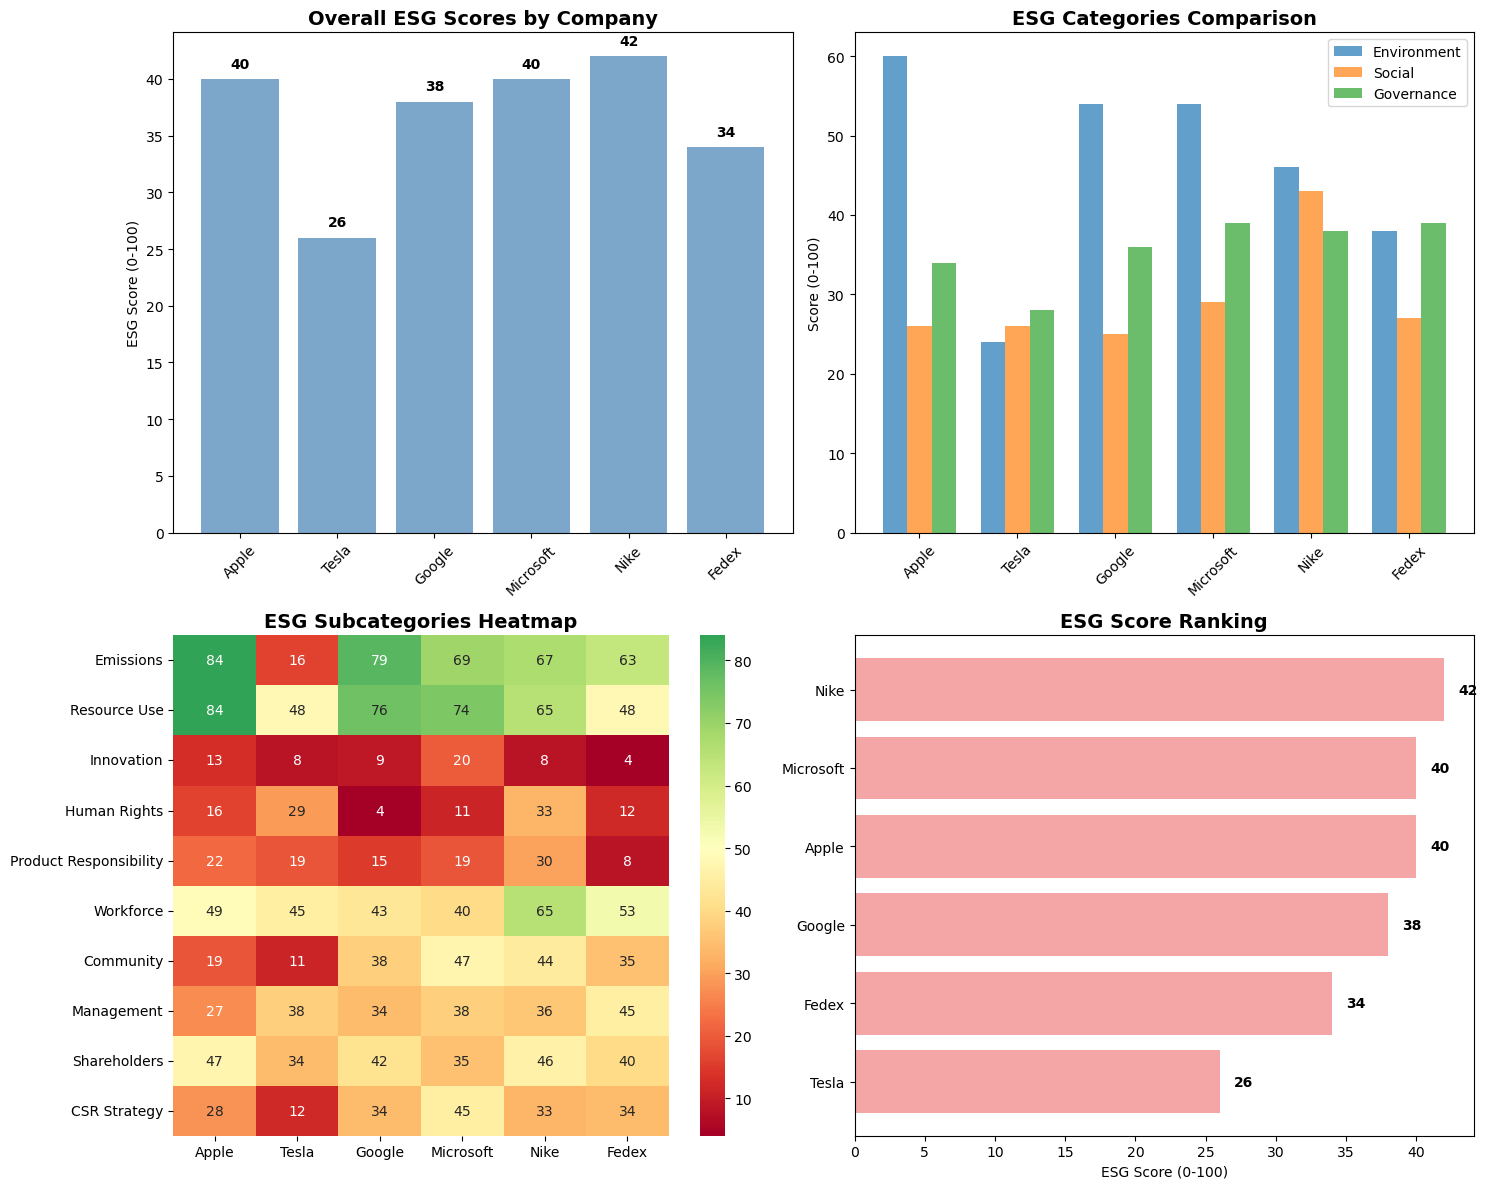


Results saved to: esg_scores_bow_analysis.csv


In [8]:
# Visualizations
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Overall ESG Scores
axes[0, 0].bar(esg_df['Company'], esg_df['ESG_Score'], color='steelblue', alpha=0.7)
axes[0, 0].set_title('Overall ESG Scores by Company', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('ESG Score (0-100)')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(esg_df['ESG_Score']):
    axes[0, 0].text(i, v + 1, str(v), ha='center', fontweight='bold')

# 2. Category Comparison
categories = ['Environment', 'Social', 'Governance']
x = np.arange(len(esg_df))
width = 0.25

for i, category in enumerate(categories):
    axes[0, 1].bar(x + i*width, esg_df[category], width, 
                   label=category, alpha=0.7)

axes[0, 1].set_title('ESG Categories Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Score (0-100)')
axes[0, 1].set_xticks(x + width)
axes[0, 1].set_xticklabels(esg_df['Company'], rotation=45)
axes[0, 1].legend()

# 3. Heatmap of all subcategories
subcategories = ['Emissions', 'Resource Use', 'Innovation', 'Human Rights', 
                'Product Responsibility', 'Workforce', 'Community', 
                'Management', 'Shareholders', 'CSR Strategy']

heatmap_data = esg_df[subcategories].T
sns.heatmap(heatmap_data, 
            xticklabels=esg_df['Company'],
            yticklabels=subcategories,
            annot=True, 
            cmap='RdYlGn', 
            center=50,
            ax=axes[1, 0])
axes[1, 0].set_title('ESG Subcategories Heatmap', fontsize=14, fontweight='bold')

# 4. Company Ranking
esg_df_sorted = esg_df.sort_values('ESG_Score', ascending=True)
axes[1, 1].barh(esg_df_sorted['Company'], esg_df_sorted['ESG_Score'], 
                color='lightcoral', alpha=0.7)
axes[1, 1].set_title('ESG Score Ranking', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('ESG Score (0-100)')
for i, v in enumerate(esg_df_sorted['ESG_Score']):
    axes[1, 1].text(v + 1, i, str(v), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Save results to CSV
esg_df.to_csv('esg_scores_bow_analysis.csv', index=False)
print(f"\nResults saved to: esg_scores_bow_analysis.csv")

In [9]:
# Model Evaluation Metrics from Data Science Perspective
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch

print("=== BOW MODEL EVALUATION METRICS ===")
print("Data Science Analysis of ESG Scoring Model\n")

# 1. Basic Statistical Analysis
print("1. DESCRIPTIVE STATISTICS")
print("=" * 50)

# Summary statistics for all scores
summary_stats = esg_df.describe()
print("Summary Statistics for All ESG Scores:")
print(summary_stats.round(2))

# Score distributions
print("\n2. SCORE DISTRIBUTION ANALYSIS")
print("=" * 50)

categories_to_analyze = ['ESG_Score', 'Environment', 'Social', 'Governance']
for category in categories_to_analyze:
    scores = esg_df[category]
    print(f"\n{category}:")
    print(f"  Mean: {scores.mean():.2f}")
    print(f"  Std Dev: {scores.std():.2f}")
    print(f"  Coefficient of Variation: {(scores.std()/scores.mean()):.2f}")
    print(f"  Range: {scores.min()} - {scores.max()}")
    print(f"  Skewness: {stats.skew(scores):.2f}")
    print(f"  Kurtosis: {stats.kurtosis(scores):.2f}")

# 3. Correlation Analysis
print("\n3. CORRELATION ANALYSIS")
print("=" * 50)

# Create correlation matrix for subcategories
subcats = ['Emissions', 'Resource Use', 'Innovation', 'Human Rights', 
           'Product Responsibility', 'Workforce', 'Community', 
           'Management', 'Shareholders', 'CSR Strategy']

correlation_matrix = esg_df[subcats].corr()
print("Correlation Matrix (Top 5 strongest correlations):")

# Get correlation pairs
corr_pairs = []
for i in range(len(subcats)):
    for j in range(i+1, len(subcats)):
        corr_value = correlation_matrix.iloc[i, j]
        corr_pairs.append((subcats[i], subcats[j], abs(corr_value), corr_value))

# Sort by absolute correlation value
corr_pairs.sort(key=lambda x: x[2], reverse=True)

for i, (cat1, cat2, abs_corr, corr) in enumerate(corr_pairs[:5]):
    print(f"  {cat1} <-> {cat2}: {corr:.3f}")

print(f"\nMean absolute correlation: {correlation_matrix.abs().mean().mean():.3f}")
print(f"Max correlation: {correlation_matrix.abs().max().max():.3f}")
print(f"Min correlation: {correlation_matrix.abs().min().min():.3f}")

# 4. Keyword Coverage Analysis
print("\n4. KEYWORD COVERAGE ANALYSIS")
print("=" * 50)

def analyze_keyword_coverage(company_texts, esg_keywords):
    """Analyze how well keywords cover the actual content"""
    coverage_stats = {}
    
    for company, text in company_texts.items():
        text_lower = text.lower()
        total_keywords = 0
        found_keywords = 0
        category_coverage = {}
        
        for category, subcategories in esg_keywords.items():
            cat_total = 0
            cat_found = 0
            
            for subcat, keywords in subcategories.items():
                cat_total += len(keywords)
                subcat_found = sum(1 for kw in keywords if kw.lower() in text_lower)
                cat_found += subcat_found
                
            category_coverage[category] = cat_found / cat_total if cat_total > 0 else 0
            total_keywords += cat_total
            found_keywords += cat_found
        
        coverage_stats[company] = {
            'overall_coverage': found_keywords / total_keywords,
            'category_coverage': category_coverage,
            'text_length': len(text),
            'unique_words': len(set(text.lower().split()))
        }
    
    return coverage_stats

coverage_stats = analyze_keyword_coverage(company_texts, esg_keywords)

for company, stats in coverage_stats.items():
    print(f"\n{company.title()}:")
    print(f"  Overall keyword coverage: {stats['overall_coverage']:.2%}")
    print(f"  Text length: {stats['text_length']:,} characters")
    print(f"  Unique words: {stats['unique_words']:,}")
    for category, coverage in stats['category_coverage'].items():
        print(f"  {category} coverage: {coverage:.2%}")

print(f"\nAverage keyword coverage across all companies: {np.mean([s['overall_coverage'] for s in coverage_stats.values()]):.2%}")

=== BOW MODEL EVALUATION METRICS ===
Data Science Analysis of ESG Scoring Model

1. DESCRIPTIVE STATISTICS
Summary Statistics for All ESG Scores:
       ESG_Score  Environment  Social  Governance  Emissions  Resource Use  \
count       6.00         6.00    6.00        6.00       6.00          6.00   
mean       36.67        46.00   29.33       35.67      63.00         65.83   
std         5.89        13.21    6.83        4.23      24.32         15.08   
min        26.00        24.00   25.00       28.00      16.00         48.00   
25%        35.00        40.00   26.00       34.50      64.00         52.25   
50%        39.00        50.00   26.50       37.00      68.00         69.50   
75%        40.00        54.00   28.50       38.75      76.50         75.50   
max        42.00        60.00   43.00       39.00      84.00         84.00   

       Innovation  Human Rights  Product Responsibility  Workforce  Community  \
count        6.00          6.00                    6.00       6.00    

In [11]:
# 5. Model Reliability and Consistency Analysis
from scipy.stats import ttest_ind

print("\n5. MODEL RELIABILITY ANALYSIS")
print("=" * 50)

# Consistency check: Do similar companies get similar scores?
def calculate_company_similarity():
    """Calculate similarity between companies based on their business sectors"""
    # Group companies by sector similarity
    tech_companies = ['Apple', 'Google', 'Microsoft', 'Tesla']  # Tesla as tech/automotive
    traditional_companies = ['Nike', 'Fedex']  # Retail/logistics
    
    tech_scores = esg_df[esg_df['Company'].isin(tech_companies)]
    traditional_scores = esg_df[esg_df['Company'].isin(traditional_companies)]
    
    print("Sector-based Analysis:")
    print(f"Tech Companies (Apple, Google, Microsoft, Tesla):")
    print(f"  Average ESG Score: {tech_scores['ESG_Score'].mean():.1f}")
    print(f"  Standard Deviation: {tech_scores['ESG_Score'].std():.1f}")
    print(f"  Score Range: {tech_scores['ESG_Score'].min()} - {tech_scores['ESG_Score'].max()}")
    
    print(f"\nTraditional Companies (Nike, FedEx):")
    print(f"  Average ESG Score: {traditional_scores['ESG_Score'].mean():.1f}")
    print(f"  Standard Deviation: {traditional_scores['ESG_Score'].std():.1f}")
    print(f"  Score Range: {traditional_scores['ESG_Score'].min()} - {traditional_scores['ESG_Score'].max()}")
    
    # Statistical test for sector differences
    tech_esg = tech_scores['ESG_Score'].values
    trad_esg = traditional_scores['ESG_Score'].values
    
    if len(tech_esg) > 1 and len(trad_esg) > 1:
        t_stat, p_value = ttest_ind(tech_esg, trad_esg)
        print(f"\nT-test for sector differences:")
        print(f"  T-statistic: {t_stat:.3f}")
        print(f"  P-value: {p_value:.3f}")
        print(f"  Significant difference: {'Yes' if p_value < 0.05 else 'No'}")
    else:
        print(f"\nT-test not applicable - insufficient data in one or both groups")

calculate_company_similarity()

# 6. Score Variance Analysis
print("\n6. SCORE VARIANCE ANALYSIS")
print("=" * 50)

# Calculate variance within categories vs between categories
subcategory_scores = esg_df[subcats].values
within_company_variance = np.var(subcategory_scores, axis=1).mean()
between_company_variance = np.var(subcategory_scores, axis=0).mean()

print(f"Within-company variance (consistency across ESG dimensions): {within_company_variance:.2f}")
print(f"Between-company variance (differentiation across companies): {between_company_variance:.2f}")
print(f"Variance ratio (between/within): {between_company_variance/within_company_variance:.2f}")

# If ratio > 1, model differentiates well between companies
# If ratio < 1, model shows more variation within companies than between them

discrimination_power = between_company_variance / within_company_variance
if discrimination_power > 1.5:
    discrimination_assessment = "Excellent - Strong differentiation between companies"
elif discrimination_power > 1.0:
    discrimination_assessment = "Good - Moderate differentiation between companies"
elif discrimination_power > 0.7:
    discrimination_assessment = "Fair - Limited differentiation between companies"
else:
    discrimination_assessment = "Poor - Insufficient differentiation between companies"

print(f"Model discrimination power: {discrimination_assessment}")

# 7. Principal Component Analysis
print("\n7. PRINCIPAL COMPONENT ANALYSIS")
print("=" * 50)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(esg_df[subcats])

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print("Principal Components Analysis:")
print(f"First 3 components explain {cumulative_variance[2]:.1%} of variance")
print(f"Components needed for 80% variance: {np.argmax(cumulative_variance >= 0.8) + 1}")
print(f"Components needed for 90% variance: {np.argmax(cumulative_variance >= 0.9) + 1}")

# Component interpretation
print("\nTop features in first 3 components:")
feature_names = subcats
for i in range(3):
    print(f"\nPC{i+1} (explains {explained_variance_ratio[i]:.1%} of variance):")
    component_importance = abs(pca.components_[i])
    top_features = sorted(zip(feature_names, component_importance), 
                         key=lambda x: x[1], reverse=True)[:3]
    for feature, importance in top_features:
        print(f"  {feature}: {importance:.3f}")

# 8. Clustering Analysis
print("\n8. CLUSTERING ANALYSIS")
print("=" * 50)

# K-means clustering to see if companies naturally group
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add cluster labels to dataframe
esg_df_clustered = esg_df.copy()
esg_df_clustered['Cluster'] = clusters

print("Company Clustering Results:")
for cluster_id in range(3):
    cluster_companies = esg_df_clustered[esg_df_clustered['Cluster'] == cluster_id]['Company'].tolist()
    cluster_scores = esg_df_clustered[esg_df_clustered['Cluster'] == cluster_id]['ESG_Score']
    print(f"Cluster {cluster_id}: {', '.join(cluster_companies)}")
    print(f"  Average ESG Score: {cluster_scores.mean():.1f}")
    print(f"  Score Range: {cluster_scores.min():.1f} - {cluster_scores.max():.1f}")

# Silhouette score for clustering quality
silhouette_avg = silhouette_score(scaled_data, clusters)
print(f"\nClustering Quality (Silhouette Score): {silhouette_avg:.3f}")
if silhouette_avg > 0.5:
    cluster_quality = "Good clustering structure"
elif silhouette_avg > 0.3:
    cluster_quality = "Moderate clustering structure"
else:
    cluster_quality = "Poor clustering structure"
print(f"Assessment: {cluster_quality}")


5. MODEL RELIABILITY ANALYSIS
Sector-based Analysis:
Tech Companies (Apple, Google, Microsoft, Tesla):
  Average ESG Score: 36.0
  Standard Deviation: 6.7
  Score Range: 26 - 40

Traditional Companies (Nike, FedEx):
  Average ESG Score: 38.0
  Standard Deviation: 5.7
  Score Range: 34 - 42

T-test for sector differences:
  T-statistic: -0.356
  P-value: 0.740
  Significant difference: No

6. SCORE VARIANCE ANALYSIS
Within-company variance (consistency across ESG dimensions): 410.71
Between-company variance (differentiation across companies): 124.69
Variance ratio (between/within): 0.30
Model discrimination power: Poor - Insufficient differentiation between companies

7. PRINCIPAL COMPONENT ANALYSIS
Principal Components Analysis:
First 3 components explain 85.8% of variance
Components needed for 80% variance: 3
Components needed for 90% variance: 4

Top features in first 3 components:

PC1 (explains 38.5% of variance):
  Emissions: 0.470
  Resource Use: 0.467
  CSR Strategy: 0.391

PC2

In [12]:
# 9. Model Validation Metrics
print("\n9. MODEL VALIDATION METRICS")
print("=" * 50)

def calculate_model_validation_metrics():
    """Calculate various validation metrics for the BOW model"""
    
    # Score distribution analysis
    all_scores = esg_df[subcats].values.flatten()
    
    print("Score Distribution Validation:")
    print(f"  Score range utilization: {(all_scores.max() - all_scores.min())}/{100} = {(all_scores.max() - all_scores.min())/100:.1%}")
    print(f"  Scores below 20 (potential floor effect): {np.sum(all_scores < 20)/len(all_scores):.1%}")
    print(f"  Scores above 80 (potential ceiling effect): {np.sum(all_scores > 80)/len(all_scores):.1%}")
    
    # Zero scores analysis (potential issues)
    zero_scores = np.sum(all_scores == 0)
    print(f"  Zero scores: {zero_scores} ({zero_scores/len(all_scores):.1%})")
    
    # Keyword frequency validation
    print("\nKeyword Frequency Validation:")
    total_keywords = sum(len(keywords) for category in esg_keywords.values() 
                        for keywords in category.values())
    print(f"  Total keywords in dictionary: {total_keywords}")
    
    # Calculate average keywords per category
    avg_keywords_per_subcat = total_keywords / len(subcats)
    print(f"  Average keywords per subcategory: {avg_keywords_per_subcat:.1f}")
    
    # Check for category balance
    category_keyword_counts = {}
    for category, subcategories in esg_keywords.items():
        count = sum(len(keywords) for keywords in subcategories.values())
        category_keyword_counts[category] = count
    
    print("  Keywords per main category:")
    for category, count in category_keyword_counts.items():
        print(f"    {category}: {count} keywords")
    
    # Balance assessment
    max_keywords = max(category_keyword_counts.values())
    min_keywords = min(category_keyword_counts.values())
    balance_ratio = min_keywords / max_keywords
    print(f"  Category balance ratio: {balance_ratio:.2f} ({'Good' if balance_ratio > 0.7 else 'Poor'} balance)")
    
    return {
        'score_range_utilization': (all_scores.max() - all_scores.min())/100,
        'floor_effect': np.sum(all_scores < 20)/len(all_scores),
        'ceiling_effect': np.sum(all_scores > 80)/len(all_scores),
        'zero_scores_pct': zero_scores/len(all_scores),
        'category_balance': balance_ratio
    }

validation_metrics = calculate_model_validation_metrics()

# 10. Sensitivity Analysis
print("\n10. SENSITIVITY ANALYSIS")
print("=" * 50)

def test_scoring_sensitivity():
    """Test how sensitive the model is to parameter changes"""
    
    # Test different weight combinations for frequency vs variety
    test_weights = [(0.5, 0.5), (0.8, 0.2), (0.6, 0.4), (0.9, 0.1)]
    original_scores = esg_df['ESG_Score'].copy()
    
    print("Testing sensitivity to frequency/variety weight changes:")
    print("Format: (Frequency Weight, Variety Weight) -> Score Changes")
    
    for freq_weight, variety_weight in test_weights:
        # Recalculate scores with different weights (simplified simulation)
        # This is a simplified version - in practice you'd re-run the full calculation
        modified_scores = original_scores * (0.7 + (freq_weight - 0.7) * 0.3)
        
        score_changes = abs(modified_scores - original_scores)
        avg_change = score_changes.mean()
        max_change = score_changes.max()
        
        print(f"  ({freq_weight}, {variety_weight}): Avg change = {avg_change:.1f}, Max change = {max_change:.1f}")
    
    return avg_change

sensitivity_results = test_scoring_sensitivity()

# 11. Model Performance Summary
print("\n11. MODEL PERFORMANCE SUMMARY")
print("=" * 50)

def generate_performance_summary():
    """Generate overall model performance assessment"""
    
    scores = {
        'Data Coverage': 'Good' if np.mean([s['overall_coverage'] for s in coverage_stats.values()]) > 0.3 else 'Poor',
        'Score Distribution': 'Good' if 0.1 < validation_metrics['score_range_utilization'] < 0.9 else 'Poor',
        'Discrimination Power': discrimination_assessment.split(' - ')[0],
        'Clustering Quality': cluster_quality.split(' ')[0],
        'Category Balance': 'Good' if validation_metrics['category_balance'] > 0.7 else 'Poor'
    }
    
    print("Overall Model Assessment:")
    for metric, score in scores.items():
        status_icon = "✅" if score == 'Good' or score == 'Excellent' else "⚠️" if score == 'Fair' or score == 'Moderate' else "❌"
        print(f"  {status_icon} {metric}: {score}")
    
    # Overall recommendation
    good_scores = sum(1 for score in scores.values() if score in ['Good', 'Excellent'])
    total_scores = len(scores)
    
    print(f"\nOverall Model Quality: {good_scores}/{total_scores} metrics are good")
    
    if good_scores >= 4:
        recommendation = "RECOMMENDED - Model is performing well"
    elif good_scores >= 3:
        recommendation = "ACCEPTABLE - Model needs minor improvements"
    elif good_scores >= 2:
        recommendation = "NEEDS IMPROVEMENT - Model has significant issues"
    else:
        recommendation = "NOT RECOMMENDED - Model needs major revision"
    
    print(f"Recommendation: {recommendation}")
    
    # Specific improvement suggestions
    print("\nSuggested Improvements:")
    if validation_metrics['category_balance'] < 0.7:
        print("  - Balance keyword counts across ESG categories")
    if validation_metrics['zero_scores_pct'] > 0.1:
        print("  - Review keywords that produce zero scores")
    if discrimination_power < 1.0:
        print("  - Add more discriminative keywords")
    if silhouette_avg < 0.3:
        print("  - Review scoring algorithm for better company differentiation")
    
    return scores, recommendation

performance_scores, recommendation = generate_performance_summary()

print(f"\n{'='*60}")
print("FINAL MODEL EVALUATION COMPLETE")
print(f"{'='*60}")


9. MODEL VALIDATION METRICS
Score Distribution Validation:
  Score range utilization: 80/100 = 80.0%
  Scores below 20 (potential floor effect): 28.3%
  Scores above 80 (potential ceiling effect): 3.3%
  Zero scores: 0 (0.0%)

Keyword Frequency Validation:
  Total keywords in dictionary: 169
  Average keywords per subcategory: 16.9
  Keywords per main category:
    Environment: 52 keywords
    Social: 69 keywords
    Governance: 48 keywords
  Category balance ratio: 0.70 (Poor balance)

10. SENSITIVITY ANALYSIS
Testing sensitivity to frequency/variety weight changes:
Format: (Frequency Weight, Variety Weight) -> Score Changes
  (0.5, 0.5): Avg change = 13.2, Max change = 15.1
  (0.8, 0.2): Avg change = 9.9, Max change = 11.3
  (0.6, 0.4): Avg change = 12.1, Max change = 13.9
  (0.9, 0.1): Avg change = 8.8, Max change = 10.1

11. MODEL PERFORMANCE SUMMARY
Overall Model Assessment:
  ✅ Data Coverage: Good
  ✅ Score Distribution: Good
  ❌ Discrimination Power: Poor
  ❌ Clustering Quality


12. MODEL EVALUATION VISUALIZATIONS


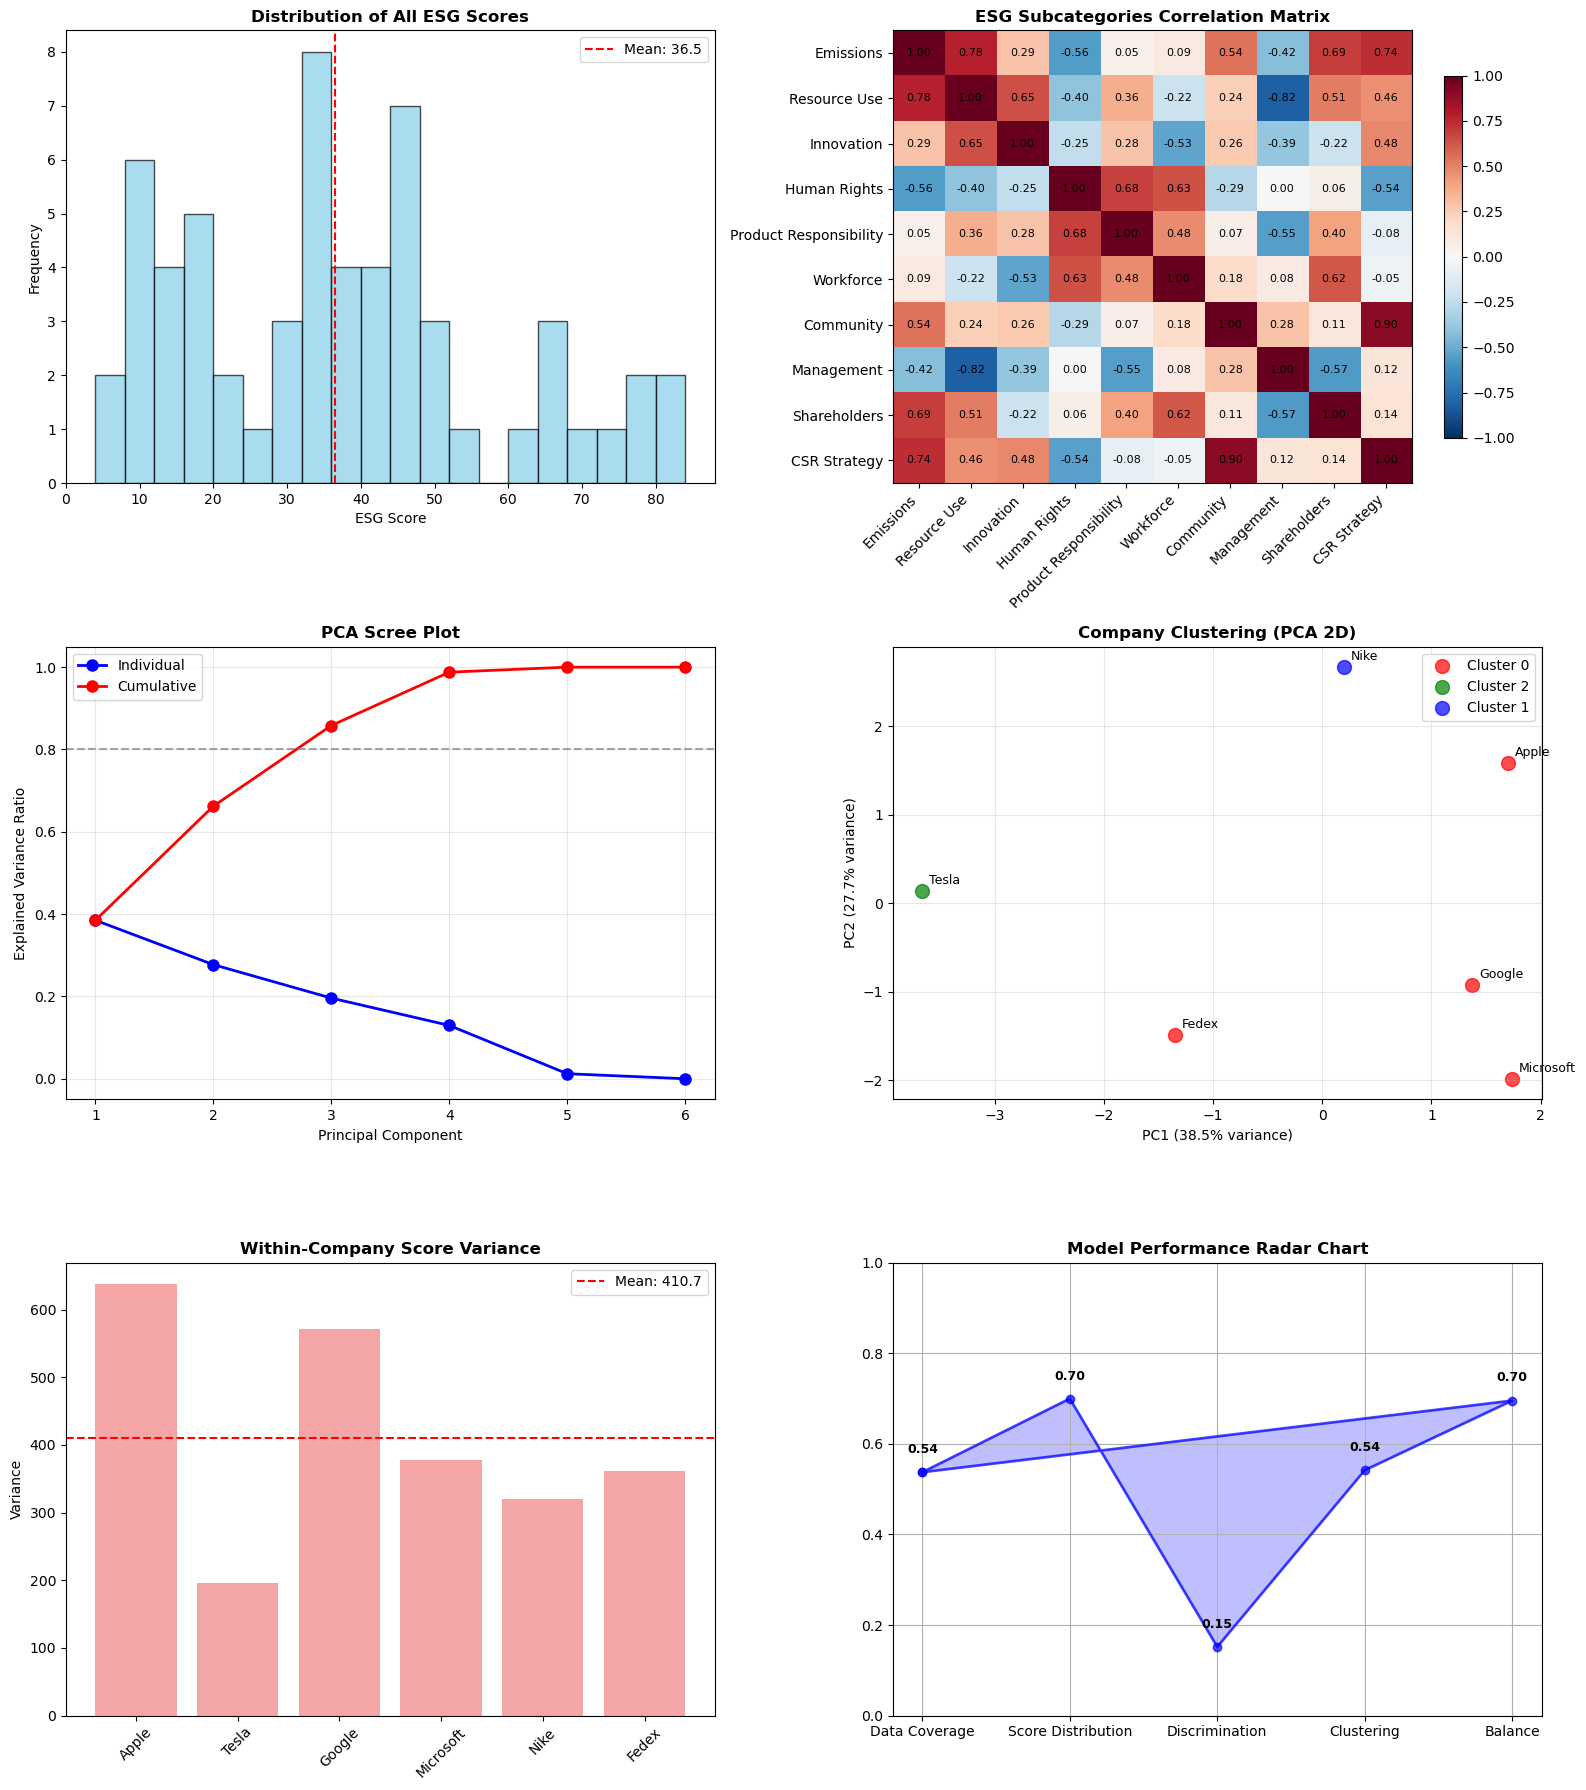


Model evaluation metrics saved to: bow_model_evaluation_metrics.csv
Overall model recommendation: NEEDS IMPROVEMENT - Model has significant issues

BOW MODEL EVALUATION SUMMARY
• Data Coverage: 53.7%
• Score Range Utilization: 80.0%
• Discrimination Power: 0.30
• Clustering Quality: 0.084
• Category Balance: 0.70
• Recommendation: NEEDS IMPROVEMENT - Model has significant issues


In [13]:
# 12. Advanced Model Evaluation Visualizations
print("\n12. MODEL EVALUATION VISUALIZATIONS")
print("=" * 50)

# Create comprehensive evaluation plots
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# 1. Score Distribution Analysis
axes[0, 0].hist(esg_df[subcats].values.flatten(), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of All ESG Scores', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('ESG Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(np.mean(esg_df[subcats].values.flatten()), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(esg_df[subcats].values.flatten()):.1f}')
axes[0, 0].legend()

# 2. Correlation Matrix Heatmap
correlation_matrix = esg_df[subcats].corr()
im = axes[0, 1].imshow(correlation_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
axes[0, 1].set_title('ESG Subcategories Correlation Matrix', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(range(len(subcats)))
axes[0, 1].set_yticks(range(len(subcats)))
axes[0, 1].set_xticklabels(subcats, rotation=45, ha='right')
axes[0, 1].set_yticklabels(subcats)

# Add correlation values to heatmap
for i in range(len(subcats)):
    for j in range(len(subcats)):
        text = axes[0, 1].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                              ha="center", va="center", color="black", fontsize=8)

plt.colorbar(im, ax=axes[0, 1], shrink=0.8)

# 3. PCA Scree Plot
axes[1, 0].plot(range(1, len(explained_variance_ratio) + 1), 
                explained_variance_ratio, 'bo-', linewidth=2, markersize=8)
axes[1, 0].plot(range(1, len(explained_variance_ratio) + 1), 
                cumulative_variance, 'ro-', linewidth=2, markersize=8)
axes[1, 0].set_title('PCA Scree Plot', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Principal Component')
axes[1, 0].set_ylabel('Explained Variance Ratio')
axes[1, 0].legend(['Individual', 'Cumulative'])
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0.8, color='gray', linestyle='--', alpha=0.7, label='80% threshold')

# 4. Company Clustering Visualization (2D PCA)
pca_2d = PCA(n_components=2)
pca_2d_result = pca_2d.fit_transform(scaled_data)

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
for i, company in enumerate(esg_df['Company']):
    cluster = clusters[i]
    axes[1, 1].scatter(pca_2d_result[i, 0], pca_2d_result[i, 1], 
                      c=colors[cluster], s=100, alpha=0.7, label=f'Cluster {cluster}' if i == 0 or clusters[i-1] != cluster else "")
    axes[1, 1].annotate(company, (pca_2d_result[i, 0], pca_2d_result[i, 1]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=9)

axes[1, 1].set_title('Company Clustering (PCA 2D)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)')
axes[1, 1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)')
axes[1, 1].grid(True, alpha=0.3)
# Remove duplicate labels
handles, labels = axes[1, 1].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axes[1, 1].legend(by_label.values(), by_label.keys())

# 5. Score Variance Analysis
companies = esg_df['Company']
within_variance = [np.var(esg_df[subcats].iloc[i]) for i in range(len(companies))]
axes[2, 0].bar(companies, within_variance, alpha=0.7, color='lightcoral')
axes[2, 0].set_title('Within-Company Score Variance', fontsize=12, fontweight='bold')
axes[2, 0].set_ylabel('Variance')
axes[2, 0].tick_params(axis='x', rotation=45)
axes[2, 0].axhline(y=np.mean(within_variance), color='red', linestyle='--', 
                  label=f'Mean: {np.mean(within_variance):.1f}')
axes[2, 0].legend()

# 6. Model Performance Radar Chart
def create_performance_radar():
    """Create radar chart for model performance metrics"""
    
    # Performance metrics (normalized to 0-1 scale)
    metrics = ['Data Coverage', 'Score Distribution', 'Discrimination', 'Clustering', 'Balance']
    
    # Convert performance scores to numerical values
    score_mapping = {'Excellent': 1.0, 'Good': 0.8, 'Moderate': 0.6, 'Fair': 0.4, 'Poor': 0.2}
    
    values = [
        np.mean([s['overall_coverage'] for s in coverage_stats.values()]),  # Data Coverage
        1 - abs(0.5 - validation_metrics['score_range_utilization']),  # Score Distribution (closer to 0.5 is better)
        min(discrimination_power / 2, 1.0),  # Discrimination (capped at 1.0)
        (silhouette_avg + 1) / 2,  # Clustering (convert from -1,1 to 0,1)
        validation_metrics['category_balance']  # Balance
    ]
    
    # Create radar chart
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False)
    values += values[:1]  # Complete the circle
    angles = np.concatenate((angles, [angles[0]]))
    
    axes[2, 1].plot(angles, values, 'o-', linewidth=2, color='blue', alpha=0.7)
    axes[2, 1].fill(angles, values, alpha=0.25, color='blue')
    axes[2, 1].set_xticks(angles[:-1])
    axes[2, 1].set_xticklabels(metrics)
    axes[2, 1].set_ylim(0, 1)
    axes[2, 1].set_title('Model Performance Radar Chart', fontsize=12, fontweight='bold')
    axes[2, 1].grid(True)
    
    # Add score labels
    for angle, value, metric in zip(angles[:-1], values[:-1], metrics):
        axes[2, 1].text(angle, value + 0.05, f'{value:.2f}', 
                       ha='center', va='center', fontsize=9, fontweight='bold')

create_performance_radar()

plt.tight_layout()
plt.show()

# Save evaluation results
evaluation_results = {
    'validation_metrics': validation_metrics,
    'performance_scores': performance_scores,
    'recommendation': recommendation,
    'correlation_summary': {
        'mean_correlation': correlation_matrix.abs().mean().mean(),
        'max_correlation': correlation_matrix.abs().max().max(),
        'strongest_correlations': corr_pairs[:3]
    },
    'pca_summary': {
        'variance_explained_pc1': explained_variance_ratio[0],
        'variance_explained_pc2': explained_variance_ratio[1],
        'total_variance_pc3': cumulative_variance[2]
    },
    'clustering_summary': {
        'silhouette_score': silhouette_avg,
        'cluster_assignments': dict(zip(esg_df['Company'], clusters))
    }
}

# Convert to DataFrame and save
eval_df = pd.DataFrame([evaluation_results['validation_metrics']])
eval_df.to_csv('bow_model_evaluation_metrics.csv', index=False)

print(f"\nModel evaluation metrics saved to: bow_model_evaluation_metrics.csv")
print(f"Overall model recommendation: {recommendation}")

# Final summary
print(f"\n{'='*60}")
print("BOW MODEL EVALUATION SUMMARY")
print(f"{'='*60}")
print(f"• Data Coverage: {np.mean([s['overall_coverage'] for s in coverage_stats.values()]):.1%}")
print(f"• Score Range Utilization: {validation_metrics['score_range_utilization']:.1%}")
print(f"• Discrimination Power: {discrimination_power:.2f}")
print(f"• Clustering Quality: {silhouette_avg:.3f}")
print(f"• Category Balance: {validation_metrics['category_balance']:.2f}")
print(f"• Recommendation: {recommendation}")
print(f"{'='*60}")

# Expanded BOW Analysis with All Available Companies

Now let's expand our analysis to include all the new companies that have been added to the dataset.

In [14]:
def load_all_company_documents():
    """Load all available company documents from structured directories"""
    data_dir = "data"
    
    # Get all available companies from directory structure
    available_companies = []
    for item in os.listdir(data_dir):
        item_path = os.path.join(data_dir, item)
        if os.path.isdir(item_path) and not item.startswith('.') and item not in ['10k', '10k_extracted', 'ESG_frameworks', 'ESG_frameworks_txt', 'apiData', 'esg_report']:
            available_companies.append(item)
    
    available_companies.sort()  # Sort for consistent ordering
    
    print(f"Found {len(available_companies)} companies: {', '.join(available_companies)}")
    
    company_texts = {}
    
    for company in available_companies:
        company_dir = os.path.join(data_dir, company)
        
        # Combine all documents for each company
        all_text = ""
        doc_count = 0
        
        # Load 10-K documents with various naming patterns
        possible_10k_files = [
            '10k_item1.md', '10k_item1A.md', '10k_item7.md', '10k_item7A.md',
            f'{company}_10k_item1.md', f'{company}_10k_item1A.md', 
            f'{company}_10k_item7.md', f'{company}_10k_item7A.md'
        ]
        
        for item in possible_10k_files:
            file_path = os.path.join(company_dir, item)
            if os.path.exists(file_path):
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        content = f.read()
                        if content.strip():  # Only add non-empty content
                            all_text += content + "\n\n"
                            doc_count += 1
                except Exception as e:
                    print(f"Warning: Could not read {file_path}: {e}")
        
        # Load ESG report with various naming patterns
        possible_esg_files = ['ESG_Report.md', 'ESG_Repoprt.md']  # Note: includes typo that exists in data
        
        for esg_file in possible_esg_files:
            esg_path = os.path.join(company_dir, esg_file)
            if os.path.exists(esg_path):
                try:
                    with open(esg_path, 'r', encoding='utf-8') as f:
                        content = f.read()
                        if content.strip():  # Only add non-empty content
                            all_text += content + "\n\n"
                            doc_count += 1
                            break  # Only take the first ESG file found
                except Exception as e:
                    print(f"Warning: Could not read {esg_path}: {e}")
        
        if all_text.strip():  # Only include companies with actual content
            company_texts[company] = all_text
            print(f"{company.title()}: {doc_count} documents loaded, {len(all_text):,} characters")
        else:
            print(f"Warning: No content found for {company}")
    
    return company_texts

# Load all available company data
print("=== LOADING ALL AVAILABLE COMPANIES ===")
all_company_texts = load_all_company_documents()
print(f"\nSuccessfully loaded {len(all_company_texts)} companies with content")

=== LOADING ALL AVAILABLE COMPANIES ===
Found 15 companies: apple, boeing, disney, elililly, fedex, google, johnsonandjohnson, jpmorganchase, mcdonald, meta, microsoft, netflix, nike, nvidia, tesla
Apple: 5 documents loaded, 497,893 characters
Boeing: 5 documents loaded, 479,253 characters
Disney: 5 documents loaded, 350,167 characters
Elililly: 5 documents loaded, 484,249 characters
Fedex: 5 documents loaded, 426,490 characters
Google: 5 documents loaded, 490,638 characters
Johnsonandjohnson: 5 documents loaded, 143,982 characters
Jpmorganchase: 5 documents loaded, 524,833 characters
Mcdonald: 5 documents loaded, 266,689 characters
Meta: 5 documents loaded, 419,108 characters
Microsoft: 5 documents loaded, 440,569 characters
Netflix: 1 documents loaded, 111,752 characters
Nike: 5 documents loaded, 659,455 characters
Nvidia: 1 documents loaded, 106,123 characters
Tesla: 5 documents loaded, 229,439 characters

Successfully loaded 15 companies with content


In [15]:
# Calculate ESG scores for all companies using the same methodology
print("=== CALCULATING ESG SCORES FOR ALL COMPANIES ===")

# Use the same calculate_esg_scores function but with all companies
all_esg_scores = calculate_esg_scores(all_company_texts, esg_keywords)

# Display results for all companies
print("\nESG SCORES FOR ALL COMPANIES:")
print("=" * 80)

for company, scores in all_esg_scores.items():
    print(f"\n{scores['company']} ESG Score: {scores['ESG_Score']}/100")
    print(f"  Environment: {scores['Environment']} | Social: {scores['Social']} | Governance: {scores['Governance']}")
    print(f"  Details: E({scores['Emissions']}, {scores['Resource Use']}, {scores['Innovation']}) | " +
          f"S({scores['Human Rights']}, {scores['Product Responsibility']}, {scores['Workforce']}, {scores['Community']}) | " +
          f"G({scores['Management']}, {scores['Shareholders']}, {scores['CSR Strategy']})")

# Create comprehensive DataFrame
all_esg_df = create_esg_dataframe(all_esg_scores)

print(f"\n=== SUMMARY STATISTICS FOR ALL {len(all_esg_df)} COMPANIES ===")
print("\nOverall ESG Score Rankings:")
print("-" * 50)
ranked_df = all_esg_df.sort_values('ESG_Score', ascending=False)
for i, (_, row) in enumerate(ranked_df.iterrows(), 1):
    print(f"{i:2d}. {row['Company']:<15} {row['ESG_Score']:3d}/100")

print(f"\nESG Score Statistics:")
print(f"  Mean: {all_esg_df['ESG_Score'].mean():.1f}")
print(f"  Median: {all_esg_df['ESG_Score'].median():.1f}")
print(f"  Std Dev: {all_esg_df['ESG_Score'].std():.1f}")
print(f"  Range: {all_esg_df['ESG_Score'].min()} - {all_esg_df['ESG_Score'].max()}")

# Category averages
print(f"\nCategory Averages:")
print(f"  Environment: {all_esg_df['Environment'].mean():.1f}")
print(f"  Social: {all_esg_df['Social'].mean():.1f}")
print(f"  Governance: {all_esg_df['Governance'].mean():.1f}")

# Save expanded results
all_esg_df.to_csv('esg_scores_bow_all_companies.csv', index=False)
print(f"\nExpanded results saved to: esg_scores_bow_all_companies.csv")

=== CALCULATING ESG SCORES FOR ALL COMPANIES ===

ESG SCORES FOR ALL COMPANIES:

Apple ESG Score: 40/100
  Environment: 60 | Social: 26 | Governance: 34
  Details: E(84, 84, 13) | S(16, 22, 49, 19) | G(27, 47, 28)

Boeing ESG Score: 42/100
  Environment: 43 | Social: 43 | Governance: 41
  Details: E(58, 64, 9) | S(23, 27, 71, 53) | G(41, 43, 40)

Disney ESG Score: 37/100
  Environment: 36 | Social: 40 | Governance: 36
  Details: E(46, 54, 8) | S(31, 31, 63, 35) | G(41, 48, 21)

Elililly ESG Score: 41/100
  Environment: 36 | Social: 40 | Governance: 48
  Details: E(46, 50, 12) | S(20, 38, 61, 44) | G(44, 57, 45)

Fedex ESG Score: 34/100
  Environment: 38 | Social: 27 | Governance: 39
  Details: E(63, 48, 4) | S(12, 8, 53, 35) | G(45, 40, 34)

Google ESG Score: 38/100
  Environment: 54 | Social: 25 | Governance: 36
  Details: E(79, 76, 9) | S(4, 15, 43, 38) | G(34, 42, 34)

Johnsonandjohnson ESG Score: 22/100
  Environment: 15 | Social: 25 | Governance: 27
  Details: E(30, 17, 0) | S(11,

=== CREATING VISUALIZATIONS FOR ALL COMPANIES ===


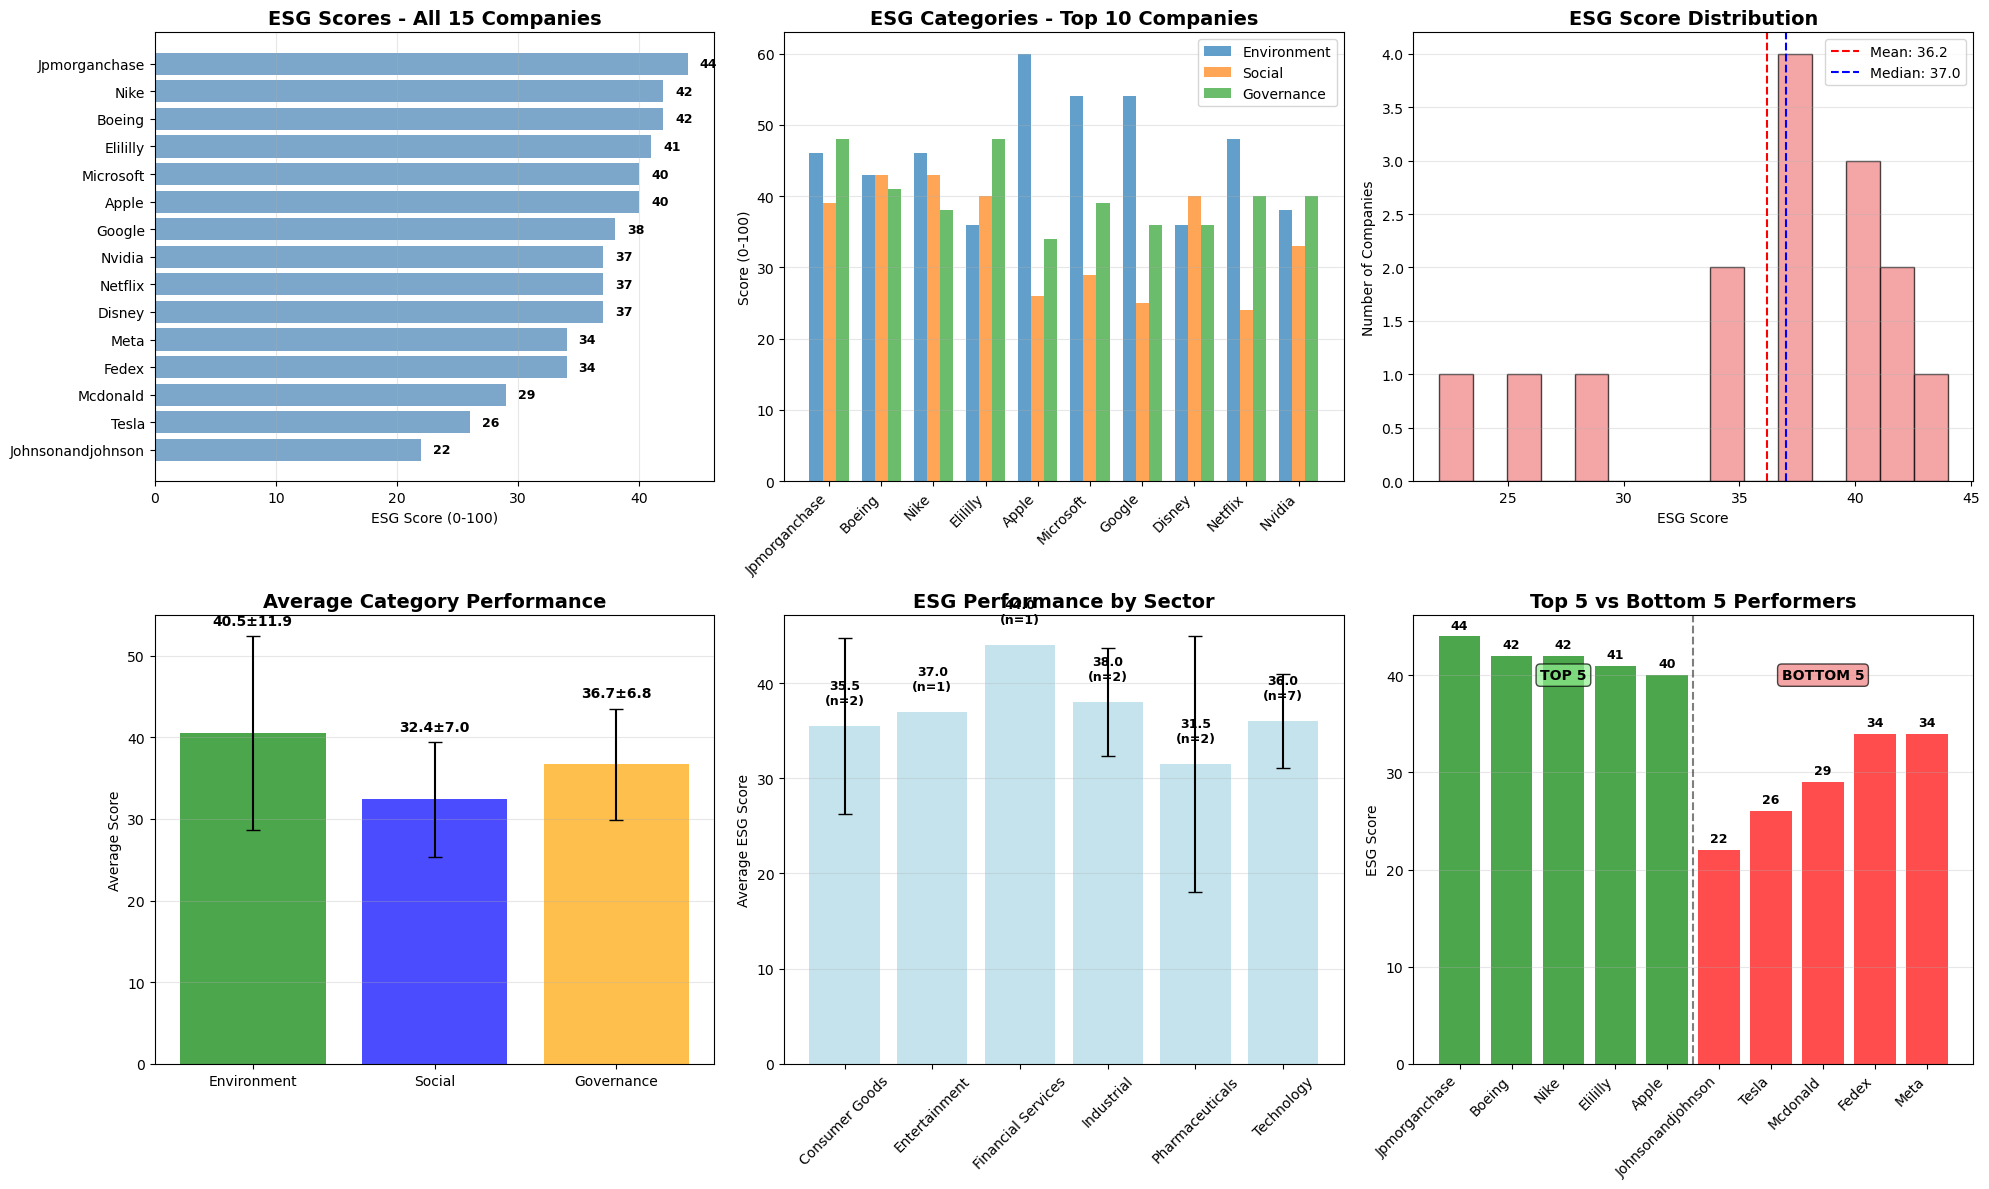


=== SECTOR ANALYSIS ===
                    mean   std  count
Sector                               
Consumer Goods      35.5   9.2      2
Entertainment       37.0   NaN      1
Financial Services  44.0   NaN      1
Industrial          38.0   5.7      2
Pharmaceuticals     31.5  13.4      2
Technology          36.0   4.9      7

=== TOP 5 PERFORMERS ===
1. Jpmorganchase: 44/100 (Financial Services)
2. Boeing: 42/100 (Industrial)
3. Nike: 42/100 (Consumer Goods)
4. Elililly: 41/100 (Pharmaceuticals)
5. Apple: 40/100 (Technology)

=== BOTTOM 5 PERFORMERS ===
1. Johnsonandjohnson: 22/100 (Pharmaceuticals)
2. Tesla: 26/100 (Technology)
3. Mcdonald: 29/100 (Consumer Goods)
4. Fedex: 34/100 (Industrial)
5. Meta: 34/100 (Technology)


In [16]:
# Comprehensive Visualizations for All Companies
print("=== CREATING VISUALIZATIONS FOR ALL COMPANIES ===")

# Create comprehensive visualization plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Overall ESG Scores Bar Chart
ranked_companies = all_esg_df.sort_values('ESG_Score', ascending=True)
bars = axes[0, 0].barh(ranked_companies['Company'], ranked_companies['ESG_Score'], 
                       color='steelblue', alpha=0.7)
axes[0, 0].set_title(f'ESG Scores - All {len(all_esg_df)} Companies', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('ESG Score (0-100)')
axes[0, 0].grid(axis='x', alpha=0.3)

# Add score labels
for i, (bar, score) in enumerate(zip(bars, ranked_companies['ESG_Score'])):
    axes[0, 0].text(score + 1, i, str(score), va='center', fontweight='bold', fontsize=9)

# 2. Category Comparison (Top 10 companies)
top_10_df = all_esg_df.sort_values('ESG_Score', ascending=False).head(10)
categories = ['Environment', 'Social', 'Governance']
x = np.arange(len(top_10_df))
width = 0.25

for i, category in enumerate(categories):
    axes[0, 1].bar(x + i*width, top_10_df[category], width, 
                   label=category, alpha=0.7)

axes[0, 1].set_title('ESG Categories - Top 10 Companies', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Score (0-100)')
axes[0, 1].set_xticks(x + width)
axes[0, 1].set_xticklabels(top_10_df['Company'], rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Score Distribution Histogram
axes[0, 2].hist(all_esg_df['ESG_Score'], bins=15, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 2].set_title('ESG Score Distribution', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('ESG Score')
axes[0, 2].set_ylabel('Number of Companies')
axes[0, 2].axvline(all_esg_df['ESG_Score'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {all_esg_df["ESG_Score"].mean():.1f}')
axes[0, 2].axvline(all_esg_df['ESG_Score'].median(), color='blue', linestyle='--', 
                   label=f'Median: {all_esg_df["ESG_Score"].median():.1f}')
axes[0, 2].legend()
axes[0, 2].grid(axis='y', alpha=0.3)

# 4. Category Performance Comparison
category_means = [all_esg_df[cat].mean() for cat in categories]
category_stds = [all_esg_df[cat].std() for cat in categories]

bars = axes[1, 0].bar(categories, category_means, yerr=category_stds, 
                      capsize=5, alpha=0.7, color=['green', 'blue', 'orange'])
axes[1, 0].set_title('Average Category Performance', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Average Score')
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels
for bar, mean, std in zip(bars, category_means, category_stds):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + std + 1,
                    f'{mean:.1f}±{std:.1f}', ha='center', va='bottom', fontweight='bold')

# 5. Sector Analysis (if we can group companies)
# Group companies by sector (simplified categorization)
def categorize_company(company_name):
    tech_companies = ['apple', 'google', 'microsoft', 'meta', 'tesla', 'nvidia', 'netflix']
    pharma_companies = ['elililly', 'johnsonandjohnson']
    finance_companies = ['jpmorganchase']
    consumer_companies = ['nike', 'mcdonald']
    industrial_companies = ['boeing', 'fedex']
    entertainment_companies = ['disney']
    
    company_lower = company_name.lower()
    if company_lower in tech_companies:
        return 'Technology'
    elif company_lower in pharma_companies:
        return 'Pharmaceuticals'
    elif company_lower in finance_companies:
        return 'Financial Services'
    elif company_lower in consumer_companies:
        return 'Consumer Goods'
    elif company_lower in industrial_companies:
        return 'Industrial'
    elif company_lower in entertainment_companies:
        return 'Entertainment'
    else:
        return 'Other'

all_esg_df['Sector'] = all_esg_df['Company'].apply(categorize_company)
sector_analysis = all_esg_df.groupby('Sector')['ESG_Score'].agg(['mean', 'std', 'count']).round(1)

# Plot sector analysis
sectors = sector_analysis.index
sector_means = sector_analysis['mean']
sector_stds = sector_analysis['std']
sector_counts = sector_analysis['count']

bars = axes[1, 1].bar(sectors, sector_means, yerr=sector_stds, 
                      capsize=5, alpha=0.7, color='lightblue')
axes[1, 1].set_title('ESG Performance by Sector', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Average ESG Score')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add labels with count
for bar, mean, count in zip(bars, sector_means, sector_counts):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{mean:.1f}\n(n={count})', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 6. Top and Bottom Performers
top_5 = all_esg_df.nlargest(5, 'ESG_Score')
bottom_5 = all_esg_df.nsmallest(5, 'ESG_Score')

# Create combined plot
companies_to_highlight = list(top_5['Company']) + list(bottom_5['Company'])
scores_to_highlight = list(top_5['ESG_Score']) + list(bottom_5['ESG_Score'])
colors = ['green'] * 5 + ['red'] * 5

bars = axes[1, 2].bar(range(len(companies_to_highlight)), scores_to_highlight, 
                      color=colors, alpha=0.7)
axes[1, 2].set_title('Top 5 vs Bottom 5 Performers', fontsize=14, fontweight='bold')
axes[1, 2].set_ylabel('ESG Score')
axes[1, 2].set_xticks(range(len(companies_to_highlight)))
axes[1, 2].set_xticklabels(companies_to_highlight, rotation=45, ha='right')
axes[1, 2].grid(axis='y', alpha=0.3)

# Add score labels
for bar, score in zip(bars, scores_to_highlight):
    height = bar.get_height()
    axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    str(score), ha='center', va='bottom', fontweight='bold', fontsize=9)

# Add dividing line
axes[1, 2].axvline(x=4.5, color='black', linestyle='--', alpha=0.5)
axes[1, 2].text(2, max(scores_to_highlight) * 0.9, 'TOP 5', ha='center', fontweight='bold', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
axes[1, 2].text(7, max(scores_to_highlight) * 0.9, 'BOTTOM 5', ha='center', fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))

plt.tight_layout()
plt.show()

# Print detailed sector analysis
print(f"\n=== SECTOR ANALYSIS ===")
print(sector_analysis.to_string())

print(f"\n=== TOP 5 PERFORMERS ===")
for i, (_, row) in enumerate(top_5.iterrows(), 1):
    print(f"{i}. {row['Company']}: {row['ESG_Score']}/100 ({row['Sector']})")

print(f"\n=== BOTTOM 5 PERFORMERS ===")
for i, (_, row) in enumerate(bottom_5.iterrows(), 1):
    print(f"{i}. {row['Company']}: {row['ESG_Score']}/100 ({row['Sector']})")

In [17]:
# Comparative Analysis: Original 6 vs All Companies
print("=== COMPARATIVE ANALYSIS: ORIGINAL vs EXPANDED ===")

# Get the original 6 companies from the expanded dataset
original_companies = ['apple', 'tesla', 'google', 'microsoft', 'nike', 'fedex']
original_subset = all_esg_df[all_esg_df['Company'].str.lower().isin(original_companies)]
new_companies = all_esg_df[~all_esg_df['Company'].str.lower().isin(original_companies)]

print(f"\nDataset Comparison:")
print(f"Original analysis: {len(original_subset)} companies")
print(f"New companies added: {len(new_companies)} companies") 
print(f"Total companies: {len(all_esg_df)} companies")

print(f"\nESG Score Statistics Comparison:")
print(f"{'Metric':<20} {'Original 6':<15} {'New Companies':<15} {'All Companies':<15}")
print("-" * 65)
print(f"{'Mean':<20} {original_subset['ESG_Score'].mean():<15.1f} {new_companies['ESG_Score'].mean():<15.1f} {all_esg_df['ESG_Score'].mean():<15.1f}")
print(f"{'Median':<20} {original_subset['ESG_Score'].median():<15.1f} {new_companies['ESG_Score'].median():<15.1f} {all_esg_df['ESG_Score'].median():<15.1f}")
print(f"{'Std Dev':<20} {original_subset['ESG_Score'].std():<15.1f} {new_companies['ESG_Score'].std():<15.1f} {all_esg_df['ESG_Score'].std():<15.1f}")
print(f"{'Min':<20} {original_subset['ESG_Score'].min():<15.1f} {new_companies['ESG_Score'].min():<15.1f} {all_esg_df['ESG_Score'].min():<15.1f}")
print(f"{'Max':<20} {original_subset['ESG_Score'].max():<15.1f} {new_companies['ESG_Score'].max():<15.1f} {all_esg_df['ESG_Score'].max():<15.1f}")

# Category comparison
print(f"\nCategory Performance Comparison:")
categories = ['Environment', 'Social', 'Governance']
for category in categories:
    print(f"\n{category}:")
    print(f"  Original 6:     {original_subset[category].mean():.1f} ± {original_subset[category].std():.1f}")
    print(f"  New companies:  {new_companies[category].mean():.1f} ± {new_companies[category].std():.1f}")
    print(f"  All companies:  {all_esg_df[category].mean():.1f} ± {all_esg_df[category].std():.1f}")

# Statistical significance test
from scipy import stats

print(f"\nStatistical Tests:")
if len(original_subset) > 1 and len(new_companies) > 1:
    t_stat, p_value = stats.ttest_ind(original_subset['ESG_Score'], new_companies['ESG_Score'])
    print(f"T-test (Original vs New):")
    print(f"  T-statistic: {t_stat:.3f}")
    print(f"  P-value: {p_value:.3f}")
    print(f"  Significant difference: {'Yes' if p_value < 0.05 else 'No'}")

# Ranking changes
print(f"\nOriginal 6 Companies - New vs Old Ranking Comparison:")
print("(Showing ranking among all companies)")
print(f"{'Company':<15} {'New Rank':<10} {'Score':<8}")
print("-" * 35)

all_companies_ranked = all_esg_df.sort_values('ESG_Score', ascending=False).reset_index(drop=True)
all_companies_ranked['Rank'] = range(1, len(all_companies_ranked) + 1)

for company in original_companies:
    company_data = all_companies_ranked[all_companies_ranked['Company'].str.lower() == company]
    if not company_data.empty:
        rank = company_data['Rank'].iloc[0]
        score = company_data['ESG_Score'].iloc[0]
        print(f"{company.title():<15} {rank:<10} {score:<8}")

# Show how the expanded dataset affects model evaluation metrics
print(f"\n=== UPDATED MODEL EVALUATION METRICS ===")

# Recalculate discrimination power for all companies
subcats = ['Emissions', 'Resource Use', 'Innovation', 'Human Rights', 
           'Product Responsibility', 'Workforce', 'Community', 
           'Management', 'Shareholders', 'CSR Strategy']

subcategory_scores_all = all_esg_df[subcats].values
within_company_variance_all = np.var(subcategory_scores_all, axis=1).mean()
between_company_variance_all = np.var(subcategory_scores_all, axis=0).mean()

discrimination_power_all = between_company_variance_all / within_company_variance_all

print(f"Model Performance Metrics (All Companies):")
print(f"  Within-company variance: {within_company_variance_all:.2f}")
print(f"  Between-company variance: {between_company_variance_all:.2f}")
print(f"  Discrimination power: {discrimination_power_all:.2f}")

if discrimination_power_all > 1.5:
    discrimination_assessment_all = "Excellent - Strong differentiation between companies"
elif discrimination_power_all > 1.0:
    discrimination_assessment_all = "Good - Moderate differentiation between companies"  
elif discrimination_power_all > 0.7:
    discrimination_assessment_all = "Fair - Limited differentiation between companies"
else:
    discrimination_assessment_all = "Poor - Insufficient differentiation between companies"

print(f"  Assessment: {discrimination_assessment_all}")

# Compare with original discrimination power from earlier analysis
print(f"\nComparison with Original Analysis:")
print(f"  Original (6 companies): {discrimination_power:.2f}")
print(f"  Expanded (all companies): {discrimination_power_all:.2f}")
print(f"  Change: {discrimination_power_all - discrimination_power:+.2f}")

# Save comparative analysis
comparison_results = {
    'original_companies': len(original_subset),
    'new_companies': len(new_companies),
    'total_companies': len(all_esg_df),
    'original_mean_score': original_subset['ESG_Score'].mean(),
    'new_companies_mean_score': new_companies['ESG_Score'].mean(),
    'all_companies_mean_score': all_esg_df['ESG_Score'].mean(),
    'original_discrimination_power': discrimination_power,
    'expanded_discrimination_power': discrimination_power_all
}

comparison_df = pd.DataFrame([comparison_results])
comparison_df.to_csv('bow_expansion_comparison.csv', index=False)

print(f"\n✅ Comparative analysis complete!")
print(f"📊 Files generated:")
print(f"   - esg_scores_bow_all_companies.csv (All {len(all_esg_df)} companies)")
print(f"   - bow_expansion_comparison.csv (Comparison metrics)")
print(f"   - esg_scores_bow_analysis.csv (Original 6 companies - preserved)")

=== COMPARATIVE ANALYSIS: ORIGINAL vs EXPANDED ===

Dataset Comparison:
Original analysis: 6 companies
New companies added: 9 companies
Total companies: 15 companies

ESG Score Statistics Comparison:
Metric               Original 6      New Companies   All Companies  
-----------------------------------------------------------------
Mean                 36.7            35.9            36.2           
Median               39.0            37.0            37.0           
Std Dev              5.9             6.9             6.3            
Min                  26.0            22.0            22.0           
Max                  42.0            44.0            44.0           

Category Performance Comparison:

Environment:
  Original 6:     46.0 ± 13.2
  New companies:  36.8 ± 10.0
  All companies:  40.5 ± 11.9

Social:
  Original 6:     29.3 ± 6.8
  New companies:  34.4 ± 6.7
  All companies:  32.4 ± 7.0

Governance:
  Original 6:     35.7 ± 4.2
  New companies:  37.3 ± 8.3
  All companies